# Linear Regression Challenge on New York Data

We begin by investigating the data on how the categories of different criminal activities may be related to each other.  Data will be cleaned and examined as we go along.  Then, PCA will be applied.  After which we can use Holdout Groups and Cross Validation to examine the accuracy of the data.

## New York Data: Clean Up
Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

In [68]:
# The objective is to make the equation equivalent to Propertycrime=α+Population+Population2+Murder+Robbery

import math
import warnings
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:3f}'.format

# Suppress warnings
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

# Bring in data
df = pd.read_csv("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv")
# Pick the fourth row as the header
df.columns = df.iloc[3]
# Rename column headers to make it easier to work with
df.columns = ['city', 'population', 'violent', 'murder', 'rape_1', 'rape_2', 'robbery', 'assault', 'property', 'burglary', 'larceny', 'motor', 'arson', 'empty']
# Remove the any lines that are empty in Population column.
df.dropna(subset=['population'], inplace=True)
# Remove another line filled with wrong data
df.drop(df.index[0], inplace=True)
# Remove NaN values
df = df.fillna(0)

df.head()

,city,population,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson,empty
4,Adams Village,"1,861",0,0,0,0,0,0,12,2,10,0,0,0.000000
5,Addison Town and Village,"2,577",3,0,0,0,0,3,24,3,20,1,0,0.000000
6,Akron Village,"2,846",3,0,0,0,0,3,16,1,15,0,0,0.000000
7,Albany,"97,956",791,8,0,30,227,526,"4,090",705,"3,243",142,0,0.000000
8,Albion Village,"6,388",23,0,0,3,4,16,223,53,165,5,0,0.000000


In [69]:
# Remove columns that will not be added to the equation.
#df = df.drop(columns=['city', 'violent', 'rape_1', 'rape_2', 'property', 'burglary', 'larceny', 'motor', 'arson', 'empty'])
df = df.drop(columns=['city', 'population', 'rape_1', 'empty'])
# Make definition to remove commas from strings
def replace(column):
    df[column] = df[column].str.replace(',', '')
    
#replace('population')
replace('violent')
replace('murder')
replace('rape_2')
replace('robbery')
replace('assault')
replace('property')
replace('burglary')
replace('larceny')
replace('motor')

# Convert type to integers
df.head()

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
4,0,0,0,0,0,12,2,10,0,0
5,3,0,0,0,3,24,3,20,1,0
6,3,0,0,0,3,16,1,15,0,0
7,791,8,30,227,526,4090,705,3243,142,0
8,23,0,3,4,16,223,53,165,5,0


In [70]:
# Convert to integer
#df.population = df.population.astype(int)
df.violent = df.violent.astype(int)
df.murder = df.murder.astype(int)
df.rape_2 = df.rape_2.astype(int)
df.robbery = df.robbery.astype(int)
df.assault = df.assault.astype(int)
df.property = df.property.astype(int)
df.burglary = df.burglary.astype(int)
df.larceny = df.larceny.astype(int)
df.motor = df.motor.astype(int)
df.arson = df.arson.astype(int)

df.head()

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
4,0,0,0,0,0,12,2,10,0,0
5,3,0,0,0,3,24,3,20,1,0
6,3,0,0,0,3,16,1,15,0,0
7,791,8,30,227,526,4090,705,3243,142,0
8,23,0,3,4,16,223,53,165,5,0


In [71]:
df.describe() # Make a summary of important data

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,201.594828,1.566092,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.005747
std,2815.268504,18.303673,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,7.884612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,6.000000,0.000000,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,22.000000,0.000000,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,0.000000
max,52384.000000,335.000000,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


In [72]:
df.var() # Return unbiased variance over requested axis

violent     7925736.748907
murder          335.024438
rape_2         3651.235309
robbery     1063028.785816
assault     2910885.478974
property   58671383.178865
burglary     855530.262910
larceny    40272407.089039
motor        162750.783489
arson            62.167114
dtype: float64

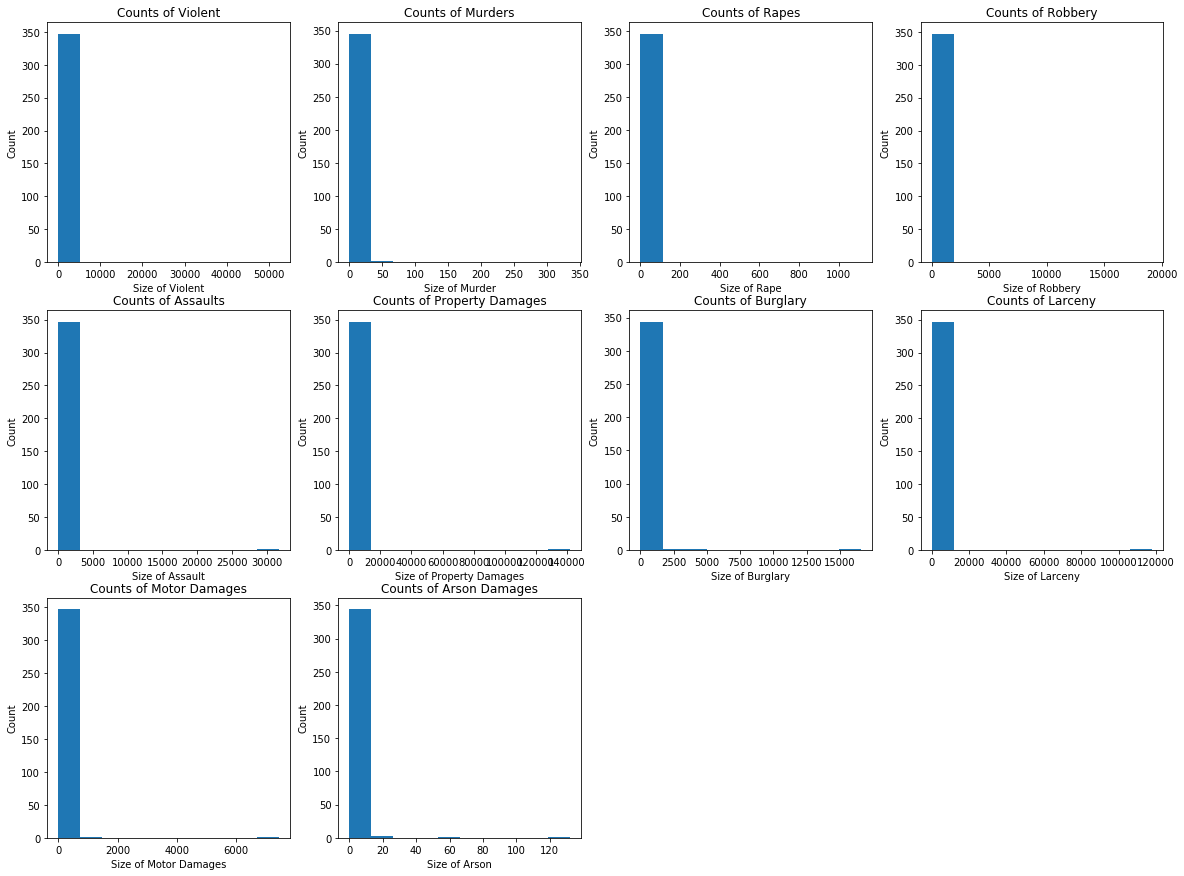

In [73]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

In [74]:
# We notice that the last three cells showed some serious outliers
df = df.sort_values('property')
df.tail(10)

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
350,1036,6,25,390,615,2368,470,1662,236,10
325,361,7,27,102,225,2528,449,1997,82,0
57,158,0,11,48,99,2689,345,2271,73,2
289,607,8,31,203,365,2800,769,1878,153,0
222,584,3,12,166,403,2807,746,1949,112,22
7,791,8,30,227,526,4090,705,3243,142,0
314,1192,21,75,400,696,6473,1781,4298,394,57
276,2107,42,92,918,1055,10051,2587,6855,609,132
39,3249,47,145,1322,1735,12491,3458,8076,957,0
220,52384,335,1112,19170,31767,141971,16606,117931,7434,0


Removed the murder, robbery, and assault because values are far too low to fit with the rest.  This also happened to relatively fit the multivariable regression equation that we will need to work with later.  

The equation is: Property crime = alpha + population + population^2 + murder + robbery

In [75]:
# Remove the outliers with extreme value (anything in the extreme thousands)
df.drop(df.index[-5:], inplace=True)
df.tail(10)

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
319,371,1,14,145,211,1985,593,1305,87,5
66,63,0,0,31,32,1990,186,1753,51,10
11,107,1,7,31,68,2118,204,1882,32,3
130,151,0,9,60,82,2303,332,1925,46,0
26,284,3,19,101,161,2349,525,1767,57,0
350,1036,6,25,390,615,2368,470,1662,236,10
325,361,7,27,102,225,2528,449,1997,82,0
57,158,0,11,48,99,2689,345,2271,73,2
289,607,8,31,203,365,2800,769,1878,153,0
222,584,3,12,166,403,2807,746,1949,112,22


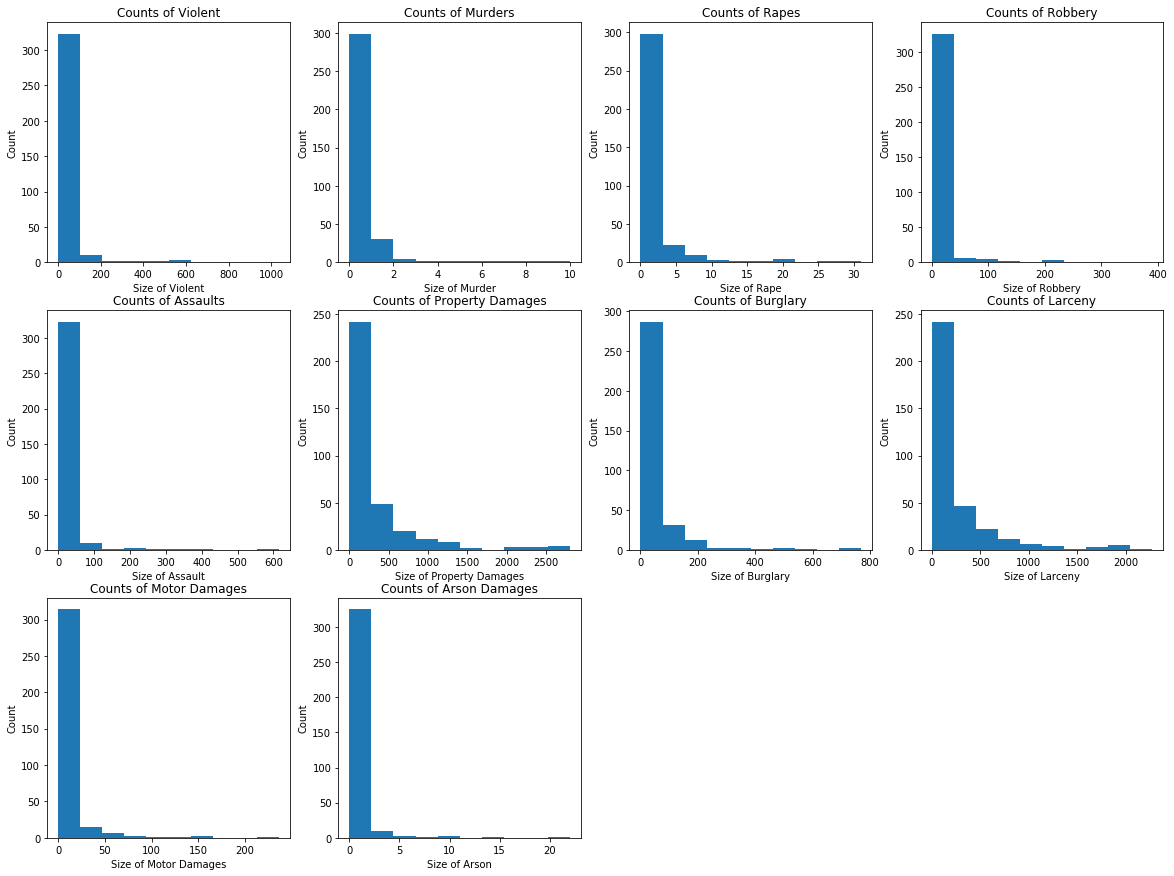

In [76]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

# Apply Linear Regression to NYC Data

In [77]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
Y = df['property']
X = df.drop(['property'],axis=1)
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-8.29455970e-15 -5.71067179e-14  3.10933205e-14  9.17114976e-15
  9.49518400e-15  1.00000000e+00  1.00000000e+00  1.00000000e+00
 -3.12730795e-18]

Intercept: 
 -1.7053025658242404e-13

R-squared:
1.0


We choose the last linear regression calculation where the coefficients, intercept, and R-squared is given.  The correlation suggests that we have a perfect predictability, therefore we need to apply PCA to retain the minimal number of variables while explaining 95% of the variance.

# Applying PCA

In [78]:
# X is the scalar of the df data.  Standardize features by removing the mean and scaling to unit variance.
# Dataset might behave badly if the individual feature do no look like standard distributed data.

# Prepare the X and Y variable, where Y is dataframe column.
# fit_transform fits the model with X and apply dimensionality reduction on X.
pca = PCA(0.95)
pca.fit(X)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
print(pca.singular_values_)

[152120.30813      7842.43378697]
[0.9443512  0.04868523]
[0.9443512  0.99303642]
[7212.84585864 1637.71559043]


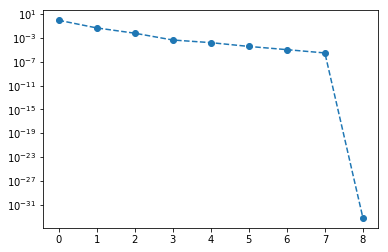

In [79]:
# Y axis says how much can be explained, where 9th variable has very small impact on predicting Property.
pca = PCA().fit(X)

plt.semilogy(pca.explained_variance_ratio_, '--o')
plt.show()

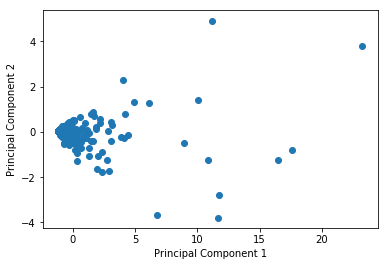

(343, 9)
(343, 4)
[[-1.13992978 -0.02886602  0.36420031  0.02863491]
 [-1.13992978 -0.02886602  0.36420031  0.02863491]
 [-1.13992978 -0.02886602  0.36420031  0.02863491]
 ...
 [ 6.15260341  0.37002736 -4.33192554  1.28919891]
 [17.62365129 -4.98809304 -0.48171483 -0.81759975]
 [16.45021978  8.68442321  0.13900582 -1.24116373]]


In [80]:
# Which variables/how many variables to keep
from sklearn.preprocessing import StandardScaler

# Each of 9 variables (out of 10) have different ranges.
# Standard Scalar makes it so all these different ranges makes sense.
# Standard = each number in the ranges are subtracted by the mean, and divided by standard deviation squared.
# Standard Scalar = same thing, but now the range is 0 to 1. Make everything comparable.
# Some examples are tests, intelligence levels, etc. Trying to standardize everyone.
X_std = StandardScaler().fit_transform(X)

# Pick the smallest number of Principal Components that explain 95% of the variables.
# That number is = to number of variables you should choose.
sklearn_pca = PCA(0.95)
Y_sklearn = sklearn_pca.fit_transform(X_std)

plt.scatter(Y_sklearn[:,0], Y_sklearn[:,3])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Each of the column is equal to the principal component.
# 343 rows, 9 columns.
# 343 rows, 4 columns.
print(X_std.shape)
print(Y_sklearn.shape)
print(Y_sklearn)

We can see that most of the data is clustered near the upper left corner, meaning that the calculation we did by hand matches the sklearn more closely in the lower values.

# Apply Linear Regression Again

In [81]:
# Instantiate linear regression
# fitting the PCA on the X_std (reduce number of variables)
# mapping of the X_std standard scalar
X_fit = sklearn_pca.fit_transform(X_std)

regr = linear_model.LinearRegression()
regr.fit(X_fit, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_fit, Y))


Coefficients: 
 [ 154.2847628    16.66800607 -279.46380207   30.85137639]

Intercept: 
 293.734693877551

R-squared:
0.9601951274680085


# Apply Residual

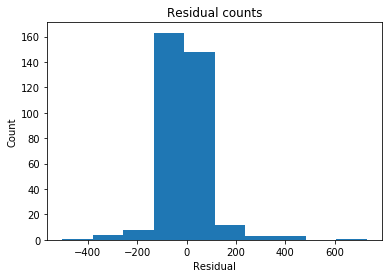

In [82]:
#### Extract predicted values.
predicted = regr.predict(X_fit).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Apply Holdout Groups and Cross Validation to Linear Regression
We want to estimate the accuracy of a linear kernel support vector machine on the dataset by splitting the data.  Then, we want to fit a model and computing the score 4 consecutive times (with different splits each time).

In [83]:
## Holdout Groups is commonly starting at 30% of data, but 1% to 50% is okay.
data = X_fit
target = Y
print(data.shape)
print(target.shape)
#print(data)
#print(target)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

# Test using the classifier, not the bernoulli this time
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)
print(clf)

# Cross Validation
# Estimate the accuracy of a linear kernel support vector machine on the dataset by splitting the data,
# fitting a model and computing the score 4 consecutive times (with different splits each time).
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, data, target, cv=4)
print(scores)

# Mean scores and 95% confidence intervals
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

(343, 4)
(343,)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


C:\Users\nyejy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


[0.01260504 0.04545455 0.03571429 0.09090909]
Accuracy: 0.05 (+/- 0.06)


# Holdout Groups and Cross Validation
Below, we want to change variables so any values greater than 0 is coded as 1.  Also, any values equal to 0 are coded as 0. This needs to be applied to all categories that we have available.  

Holdout Groups is where we select a few of the data for testing only.  This will allow us to evaluate whether our data is overfitting or not.  We want to avoid having out model complex to the point that it starts to catch random noises.  Cross Validation is similar to Holdout Groups, but depends on a different method to operate.  Instead of creating just a single holdout, several holdouts are created

In [84]:
df1 = df.copy()
df1['violent'][df1['violent'] > 0] = 1
df1['murder'][df1['murder'] > 0] = 1
df1['rape_2'][df1['rape_2'] > 0] = 1
df1['robbery'][df1['robbery'] > 0] = 1
df1['assault'][df1['assault'] > 0] = 1
df1['property'][df1['property'] > 0] = 1
df1['burglary'][df1['burglary'] > 0] = 1
df1['larceny'][df1['larceny'] > 0] = 1
df1['motor'][df1['motor'] > 0] = 1
df1['arson'][df1['arson'] > 0] = 1
df1.head()

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
212,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0
291,0,0,0,0,0,0,0,0,0,0
323,0,0,0,0,0,0,0,0,0,0
299,0,0,0,0,0,0,0,0,0,0


Here we put down more data to compare, making about 6 out of 14 categories.  Rape, property, burglary, larceny, motor, and arson seem to be lead to murder. The below scores are consistent and shows that we are not overfitting for just the Holdout Group.  

However, the array of 10 folds showed that we have a pretty consistent percentage ranging anywhere from the mid 70% to mid 90%.  This series of accuracy scores represent different holdout groups for each time.  Because they are fluctuating, we can say that they are overfitting.  We need to try a different training set.

In [85]:
data = df1[['rape_2', 'property', 'burglary', 'larceny', 'motor', 'arson']]
target = df1['murder']

## Holdout Groups is commonly starting at 30% of data, but 1% to 50% is okay.
print(data.shape)
print(target.shape)
#print(data)
#print(target)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

# Test using the classifier, not the bernoulli this time
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)
print(clf)

# Cross Validation
# Estimate the accuracy of a linear kernel support vector machine on the dataset by splitting the data,
# fitting a model and computing the score 4 consecutive times (with different splits each time).
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, data, target, cv=4)
print(scores)

# Mean scores and 95% confidence intervals
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

(343, 6)
(343,)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0.87209302 0.87209302 0.87209302 0.87058824]
Accuracy: 0.87 (+/- 0.00)


Here we see if murder and robbery include assault, which means 2 out of 14 categories are selected. The below scores are consistent and shows that we are not overfitting.  However, the cross validation looks too normal with all the 80% accuracy rate.  Maybe try another set.

In [86]:
# Simply do not include all of the data in the training set.
data = df1[['murder', 'robbery']]
target = df1['assault']

## Holdout Groups is commonly starting at 30% of data, but 1% to 50% is okay.
print(data.shape)
print(target.shape)
#print(data)
#print(target)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

# Test using the classifier, not the bernoulli this time
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)
print(clf)

# Cross Validation
# Estimate the accuracy of a linear kernel support vector machine on the dataset by splitting the data,
# fitting a model and computing the score 4 consecutive times (with different splits each time).
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, data, target, cv=4)
print(scores)

# Mean scores and 95% confidence intervals
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

(343, 2)
(343,)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0.40229885 0.80232558 0.81176471 0.81176471]
Accuracy: 0.71 (+/- 0.35)


Here we see if murder and robbery are related to violent category, which means 2 out of 14 categories are selected.  The below scores are consistent and shows that we are not overfitting.  This is a pretty good model to work with.

# Apply Test Statistics

In [87]:
# Write out the model formula for first data
linear_formula = 'property ~ rape_2+murder+assault'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df1).fit()

In [88]:
lm.params

Intercept    0.908091
rape_2       0.009425
murder      -0.004338
assault      0.088106
dtype: float64

In [89]:
lm.pvalues

Intercept   0.000000
rape_2      0.541685
murder      0.843928
assault     0.000002
dtype: float64

In [90]:
lm.rsquared

0.07574094546780097

In [91]:
lm.conf_int()

,0,1
Intercept,0.877228,0.938955
rape_2,-0.020923,0.039774
murder,-0.047642,0.038966
assault,0.052182,0.124030


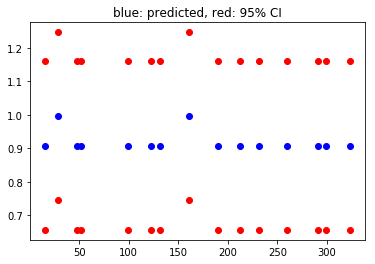

In [92]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

# Second Data: California

In [93]:
# Bring in data
df2 = pd.read_csv("table_8_offenses_known_to_law_enforcement_california_by_city_2013.csv")
# Pick the fourth row as the header
df2.columns = df2.iloc[3]
# Rename column headers to make it easier to work with
df2.columns = ['city', 'population', 'violent', 'murder', 'rape_1', 'rape_2', 'robbery', 'assault', 'property', 'burglary', 'larceny', 'motor', 'arson', 'empty']
# Remove the any lines that are empty in Population column.
df2.dropna(subset=['population'], inplace=True)
# Remove another line filled with wrong data
df2.drop(df2.index[0], inplace=True)
# Remove NaN values
df2 = df2.fillna(0)

df2.head()

,city,population,violent,murder,rape_1,rape_2,robbery,assault,property,burglary,larceny,motor,arson,empty
4,Adelanto,"31,165",198,2,0,15,52,129,886,381,372,133,17,0.000000
5,Agoura Hills,"20,762",19,0,0,2,10,7,306,109,185,12,7,0.000000
6,Alameda,"76,206",158,0,0,10,85,63,"1,902",287,"1,285",330,17,0.000000
7,Albany,"19,104",29,0,0,1,24,4,557,94,388,75,7,0.000000
8,Alhambra,"84,710",163,1,0,9,81,72,"1,774",344,"1,196",234,7,0.000000


In [94]:
# Remove columns that will not be added to the equation.
df2 = df2.drop(columns=['city', 'population', 'rape_1', 'empty'])
# Make definition to remove commas from strings
def replace(column):
    df2[column] = df2[column].str.replace(',', '')
    
#replace('population')
replace('violent')
replace('murder')
replace('rape_2')
replace('robbery')
replace('assault')
replace('property')
replace('burglary')
replace('larceny')
replace('motor')
replace('arson')

# Convert type to integers
df2.head()

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
4,198,2,15,52,129,886,381,372,133,17
5,19,0,2,10,7,306,109,185,12,7
6,158,0,10,85,63,1902,287,1285,330,17
7,29,0,1,24,4,557,94,388,75,7
8,163,1,9,81,72,1774,344,1196,234,7


In [95]:
# Convert to integer
df2.violent = df2.violent.astype(int)
df2.murder = df2.murder.astype(int)
df2.rape_2 = df2.rape_2.astype(int)
df2.robbery = df2.robbery.astype(int)
df2.assault = df2.assault.astype(int)
df2.property = df2.property.astype(int)
df2.burglary = df2.burglary.astype(int)
df2.larceny = df2.larceny.astype(int)
df2.motor = df2.motor.astype(int)
df2.arson = df2.arson.astype(int)

df2.head()

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
4,198,2,15,52,129,886,381,372,133,17
5,19,0,2,10,7,306,109,185,12,7
6,158,0,10,85,63,1902,287,1285,330,17
7,29,0,1,24,4,557,94,388,75,7
8,163,1,9,81,72,1774,344,1196,234,7


In [96]:
df2.describe() # Make a summary of important data

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,269.692641,3.030303,13.125541,103.971861,149.564935,1883.084416,412.158009,1168.404762,302.521645,13.426407
std,1004.375521,13.711276,43.273952,493.353465,476.014021,5427.650545,1026.459128,3512.717199,982.348315,70.413206
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000
25%,27.000000,0.000000,2.000000,5.000000,17.000000,281.000000,75.500000,161.250000,22.000000,1.000000
50%,77.500000,0.000000,5.000000,21.000000,51.000000,721.000000,175.000000,444.500000,77.000000,3.000000
75%,200.750000,2.000000,12.000000,65.750000,120.000000,1879.250000,401.250000,1194.500000,250.500000,10.000000
max,16524.000000,251.000000,764.000000,7885.000000,7624.000000,85844.000000,15728.000000,55734.000000,14382.000000,1430.000000


In [97]:
df2.var() # Return unbiased variance over requested axis

violent     1008770.187321
murder          187.999080
rape_2         1872.634964
robbery      243397.641289
assault      226589.348269
property   29459390.441882
burglary    1053618.341573
larceny    12339182.119977
motor        965008.211027
arson          4958.019518
dtype: float64

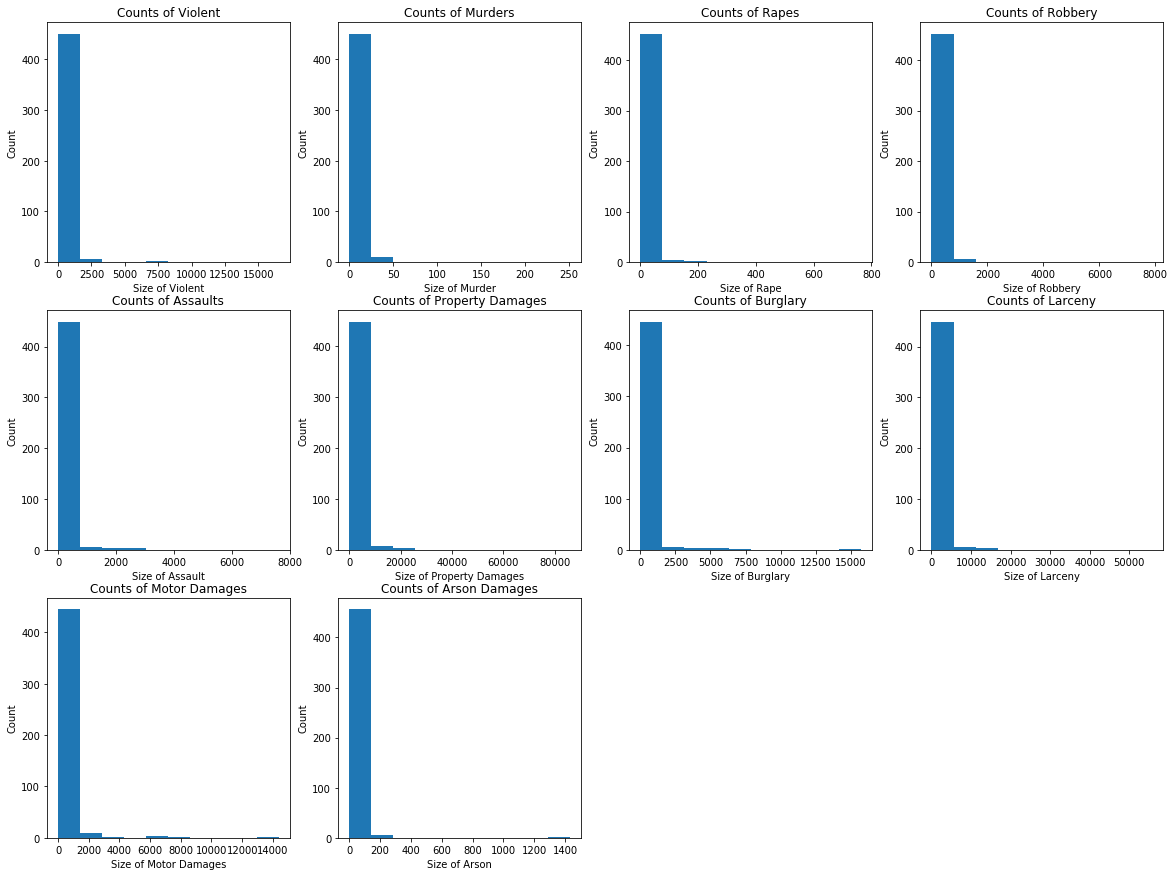

In [98]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df2.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df2.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df2.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df2.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df2.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df2.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df2.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df2.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df2.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df2.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

In [99]:
# We notice that the last three cells showed some serious outliers
df2 = df2.sort_values('property')
df2.tail(10)

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
234,2346,34,103,1118,1091,12999,3776,6868,2355,97
409,3622,32,91,1088,2411,15080,4189,8748,2143,88
28,1857,24,43,708,1082,16814,4605,9272,2937,193
351,3137,34,95,1158,1850,17980,3886,11233,2861,164
152,2552,40,53,903,1556,22584,5223,13304,4057,184
286,7984,90,180,4922,2792,25176,5058,13285,6833,140
364,3215,38,270,1095,1812,25510,5173,12411,7926,133
357,5303,39,316,1456,3492,31728,6355,19230,6143,178
360,7064,48,161,4202,2653,48324,5931,36527,5866,227
238,16524,251,764,7885,7624,85844,15728,55734,14382,1430


In [100]:
# Remove the outliers with extreme value (anything in the extreme thousands)
df2.drop(df2.index[-2:], inplace=True)
df2.tail(10)

,violent,murder,rape_2,robbery,assault,property,burglary,larceny,motor,arson
259,1704,14,72,450,1168,9989,2251,6349,1389,62
343,1330,10,78,495,747,10608,1978,6912,1718,75
234,2346,34,103,1118,1091,12999,3776,6868,2355,97
409,3622,32,91,1088,2411,15080,4189,8748,2143,88
28,1857,24,43,708,1082,16814,4605,9272,2937,193
351,3137,34,95,1158,1850,17980,3886,11233,2861,164
152,2552,40,53,903,1556,22584,5223,13304,4057,184
286,7984,90,180,4922,2792,25176,5058,13285,6833,140
364,3215,38,270,1095,1812,25510,5173,12411,7926,133
357,5303,39,316,1456,3492,31728,6355,19230,6143,178


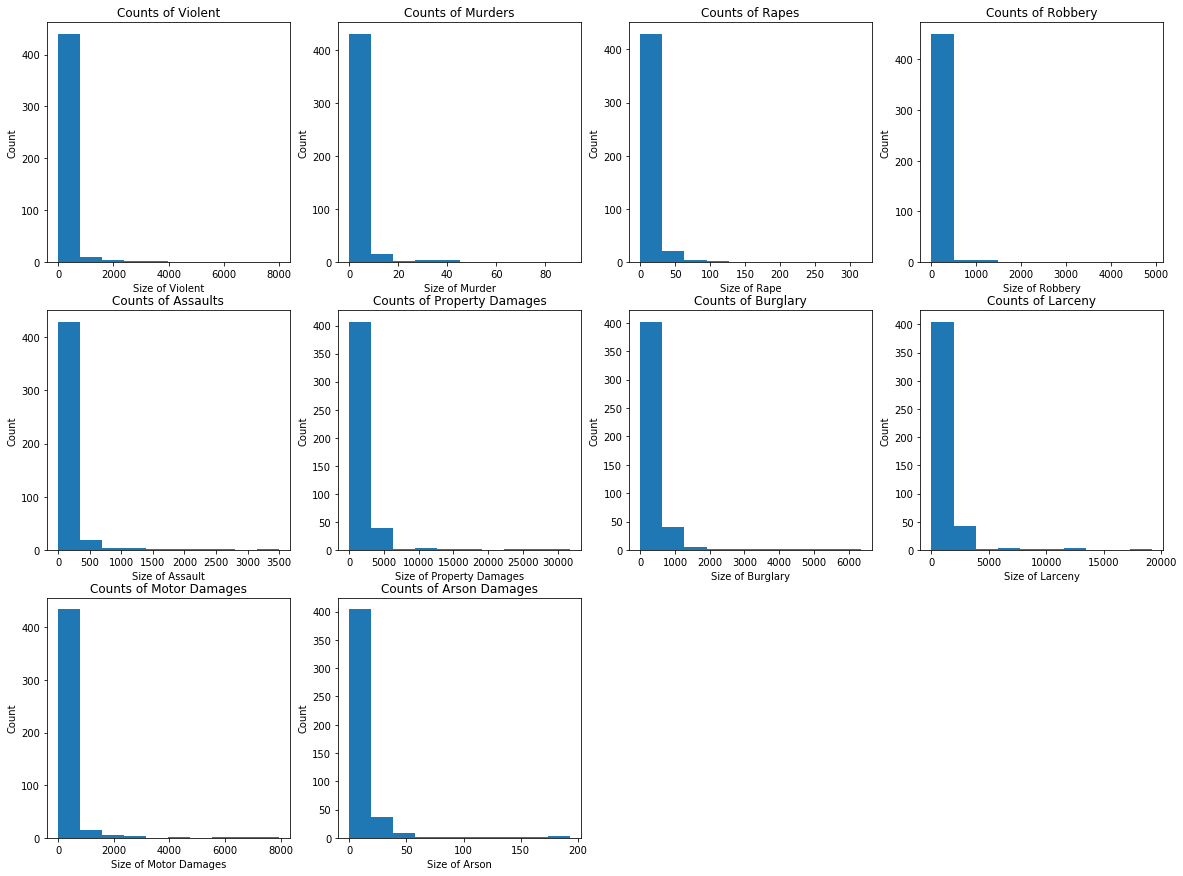

In [101]:
# Plot some comparisons so we know the distribution
plt.figure(figsize=(20, 15))

plt.subplot(3, 4, 1)
plt.hist(df2.violent)
plt.ylabel('Count')
plt.xlabel('Size of Violent')
plt.title('Counts of Violent')

plt.subplot(3, 4, 2)
plt.hist(df2.murder)
plt.ylabel('Count')
plt.xlabel('Size of Murder')
plt.title('Counts of Murders')

plt.subplot(3, 4, 3)
plt.hist(df2.rape_2)
plt.ylabel('Count')
plt.xlabel('Size of Rape')
plt.title('Counts of Rapes')

plt.subplot(3, 4, 4)
plt.hist(df2.robbery)
plt.ylabel('Count')
plt.xlabel('Size of Robbery')
plt.title('Counts of Robbery')

plt.subplot(3, 4, 5)
plt.hist(df2.assault)
plt.ylabel('Count')
plt.xlabel('Size of Assault')
plt.title('Counts of Assaults')

plt.subplot(3, 4, 6)
plt.hist(df2.property)
plt.ylabel('Count')
plt.xlabel('Size of Property Damages')
plt.title('Counts of Property Damages')

plt.subplot(3, 4, 7)
plt.hist(df2.burglary)
plt.ylabel('Count')
plt.xlabel('Size of Burglary')
plt.title('Counts of Burglary')

plt.subplot(3, 4, 8)
plt.hist(df2.larceny)
plt.ylabel('Count')
plt.xlabel('Size of Larceny')
plt.title('Counts of Larceny')

plt.subplot(3, 4, 9)
plt.hist(df2.motor)
plt.ylabel('Count')
plt.xlabel('Size of Motor Damages')
plt.title('Counts of Motor Damages')

plt.subplot(3, 4, 10)
plt.hist(df2.arson)
plt.ylabel('Count')
plt.xlabel('Size of Arson')
plt.title('Counts of Arson Damages')

plt.show()

# Apply Linear Regression to CA Data

In [102]:
# Instantiate linear regression
regr2 = linear_model.LinearRegression()
Y2 = df2['property']
X2 = df2.drop(['property'],axis=1)
regr2.fit(X2, Y2)
                    
# Check the results
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X2, Y2))


Coefficients: 
 [ 9.69864858e-15  3.55378371e-14 -1.06596288e-14 -7.09679326e-15
 -6.70070750e-15  1.00000000e+00  1.00000000e+00  1.00000000e+00
  2.69669179e-15]

Intercept: 
 -4.547473508864641e-13

R-squared:
1.0


# Applying PCA

In [103]:
# X is the scalar of the df data.  Standardize features by removing the mean and scaling to unit variance.
# Dataset might behave badly if the individual feature do no look like standard distributed data.

# Prepare the X and Y variable, where Y is dataframe column.
# fit_transform fits the model with X and apply dimensionality reduction on X.
pca2 = PCA(0.95)
pca2.fit(X2)

print(pca2.explained_variance_)
print(pca2.explained_variance_ratio_)
print(pca2.explained_variance_ratio_.cumsum())
print(pca2.singular_values_)

[4373714.18987459]
[0.95213553]
[0.95213553]
[44805.52212789]


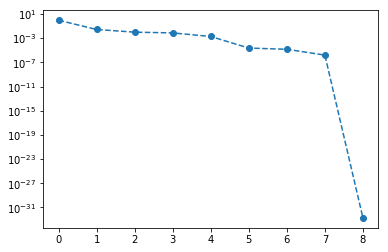

In [104]:
# Y axis says how much can be explained, where 9th variable has very small impact on predicting Property.
pca2 = PCA().fit(X2)

plt.semilogy(pca2.explained_variance_ratio_, '--o')
plt.show()

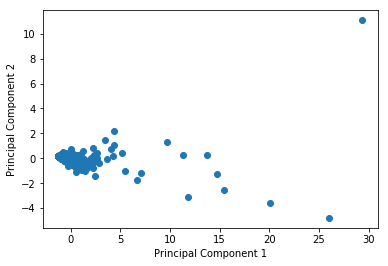

(460, 9)
(460, 3)
[[-1.24800869e+00  1.88844625e-01  1.69958196e-02]
 [-1.24732100e+00  1.95712541e-01 -3.80725949e-02]
 [-1.25798128e+00  2.08028371e-01 -1.01201732e-02]
 ...
 [ 2.93772816e+01  1.10662662e+01 -5.78127443e-01]
 [ 2.01157114e+01 -3.60142186e+00 -4.16824530e+00]
 [ 2.59987761e+01 -4.77557749e+00 -4.07213266e+00]]


In [105]:
# Which variables/how many variables to keep
from sklearn.preprocessing import StandardScaler

# Each of 9 variables (out of 10) have different ranges.
# Standard Scalar makes it so all these different ranges makes sense.
# Standard = each number in the ranges are subtracted by the mean, and divided by standard deviation squared.
# Standard Scalar = same thing, but now the range is 0 to 1. Make everything comparable.
# Some examples are tests, intelligence levels, etc. Trying to standardize everyone.
X_std2 = StandardScaler().fit_transform(X2)

# Pick the smallest number of Principal Components that explain 95% of the variables.
# That number is = to number of variables you should choose.
sklearn_pca2 = PCA(0.95)
Y_sklearn2 = sklearn_pca2.fit_transform(X_std2)

plt.scatter(Y_sklearn2[:,0], Y_sklearn2[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Each of the column is equal to the principal component.
# 343 rows, 9 columns.
# 343 rows, 4 columns.
print(X_std2.shape)
print(Y_sklearn2.shape)
print(Y_sklearn2)

# Apply Linear Regression Again

In [106]:
# Instantiate linear regression
# fitting the PCA on the X_std (reduce number of variables)
# mapping of the X_std standard scalar
X_fit2 = sklearn_pca2.fit_transform(X_std2)

regr2 = linear_model.LinearRegression()
regr2.fit(X_fit2, Y2)
                    
# Check the results
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X_fit2, Y2))


Coefficients: 
 [1067.83401743 -777.20950426  -55.75505776]

Intercept: 
 1599.6021739130435

R-squared:
0.9796738960838218


# Apply Residual

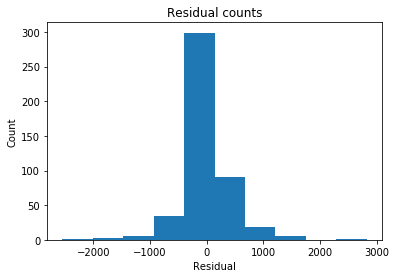

In [107]:
#### Extract predicted values.
predicted2 = regr2.predict(X_fit2).ravel()
actual2 = Y2

# Calculate the error, also called the residual.
residual2 = actual2 - predicted2

# This looks a bit concerning.
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Apply Test Statistics

In [108]:
# A model formula is written to describe the equation of violent column
linear_formula2 = 'violent ~ murder+assault'

# Fit the model to our data using this formula
lm2 = smf.ols(formula=linear_formula, data=df2).fit()

In [109]:
lm2.params

Intercept   310.740536
rape_2       43.966268
murder       55.195522
assault       5.204914
dtype: float64

In [110]:
lm2.pvalues

Intercept   0.000000
rape_2      0.000000
murder      0.000023
assault     0.000000
dtype: float64

In [111]:
lm2.rsquared

0.9021318142898382

In [112]:
lm2.conf_int()

,0,1
Intercept,213.479076,408.001997
rape_2,35.887723,52.044814
murder,29.863759,80.527285
assault,4.327383,6.082445


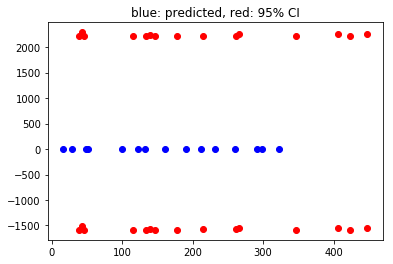

In [113]:
# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm2)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()